In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
import math
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
import scipy.stats
import seaborn as sns
from IPython.display import Image
from pysal.viz.mapclassify import Natural_Breaks as nb
from pysal.viz.mapclassify import Equal_Interval, User_Defined, Fisher_Jenks, Jenks_Caspall

from matplotlib.collections import PatchCollection
import matplotlib as mpl
from collections import defaultdict
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import Polygon

In [13]:
import matplotlib

#matplotlib.use('pgf')

def figsize(scale,ratio):
    fig_width_pt = 500.484                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "pgf.preamble": [
        r'\usepackage[light,math]{kurier}',
        r'\usepackage{amsmath}',
#        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
#        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
matplotlib.rcParams.update(pgf_with_latex)

#plt.rcParams['axes.facecolor']='w'
plt.rcParams['axes.edgecolor']='k'
#plt.rcParams['text.color']='555555'

In [14]:
def fill_intervals(ax, steps, X, Y):
    last_step = None
    coordinates = []

    for i in range(1, len(steps)):
        if last_step == X.shape[0]:
            continue
        elif last_step is None:
            lower = np.argwhere(X >= steps[i-1])[0,0]
        else:
            lower = last_step
        
        if steps[i] == 1:
            upper = X.shape[0]-1
        elif i == len(steps)-1:
            upper = X.shape[0]-1
        else:
            upper = np.argwhere(X < steps[i])[-1, 0]
        
        if not upper:
            upper = X.shape[0]-1
            
        ax.fill_between(
            X[lower: upper+1],
            Y[lower: upper+1],
            color=color_cmap[i-1],
            alpha=1,
            linewidth=0, zorder=2
        )
        coordinates.append([steps[i-1], steps[i], Y[lower], Y[upper]])
        
        ax.plot([0, X[upper]], [Y[lower], Y[upper]], '--', color=np.array((200,200,200))/255, zorder=0)
        
        last_step = upper
        print(X[lower], Y[lower])
        
    return ax, coordinates

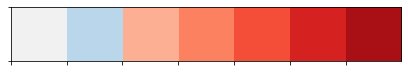

In [5]:
color_cmap = sns.color_palette("Reds", 6) #sns.cubehelix_palette(6, dark=0)#
color_cmap = np.hstack((color_cmap, np.ones((len(color_cmap), 1))))
background = np.hstack([np.array([241,241,241])/255., [1]])
#final = np.hstack([np.array([0,0,0])/255., [1]])
color_cmap = np.vstack((background, color_cmap))
#color_cmap = np.vstack((color_cmap, final))

# blue
color_cmap[1] = np.hstack([np.array([186,214,234])/255., [1]])

sns.palplot(color_cmap)

In [32]:
df = pd.read_csv('../data/generated_files/macro_05x05.csv')
df.loc[df['tile_km2'] < 0, 'tile_km2'] = 0

df['percent_urban'] = (df['urban_area_km2']/df['tile_km2'])*100
df.loc[df['percent_urban']<0, 'percent_urban'] = 0
df.loc[df['percent_urban']>100, 'percent_urban'] = 100
df = df.sort_values(['macro', 'percent_urban', 'tile_km2']).dropna()
df.head()

,macro,tileid,urban_area_km2,num_urban,tile_km2,percent_urban
171,Australia N. Zealand,69018,0.0,0,0.000457,0.0
172,Australia N. Zealand,69022,0.0,0,0.001430,0.0
165,Australia N. Zealand,68318,0.0,0,0.001996,0.0
2591,Australia N. Zealand,97291,0.0,0,0.052218,0.0
202,Australia N. Zealand,71086,0.0,0,0.158859,0.0


In [33]:
filtered_data = df.groupby('tileid').sum()['percent_urban'].values
#filtered_data = filtered_data[filtered_data > 0]

#steps = jenks(filtered_data, 7)
#steps

In [34]:
#steps = [0, 0.50, 0.80, 0.90, 0.95, 0.99, 1]
steps = [0, 0.01, 1.43, 4, 10, 30, 60, 100]

# Map

In [35]:
# Create some test data
df_summary = pd.read_csv('../data/generated_files/summary_tiles_05x05.csv')
df_summary.loc[df_summary['tile_km2']<0, 'tile_km2'] = 0

df_summary.loc[:, 'tile_km2_norm'] = df_summary['tile_km2']/df_summary['tile_km2'].sum()
df_summary['percent_urban'] = (df_summary['urban_area_km2']/df_summary['tile_km2'])*100
df_summary.loc[df_summary['percent_urban']<0, 'percent_urban'] = 0
df_summary.loc[df_summary['percent_urban']>100, 'percent_urban'] = 100
df_summary = df_summary.sort_values(['percent_urban', 'tile_km2'])
df_summary.head()

,tileid,urban_area_km2,urban_num,tile_km2,original_km2,tile_km2_norm,percent_urban
19190,147342,0.0,0,0.000001,2972.529465,9.394477e-15,0.0
36802,187888,0.0,0,0.000235,2237.358095,2.207702e-12,0.0
770,69018,0.0,0,0.000457,2362.722662,4.293276e-12,0.0
21860,155223,0.0,0,0.000700,2883.264965,6.576134e-12,0.0
771,69022,0.0,0,0.001430,2362.722662,1.343410e-11,0.0


In [36]:
df_summary['percent_urban'].mean()

1.4904434408737337

In [37]:
df_summary['urban_area_km2'].sum()/df_summary['tile_km2'].sum()

0.010407896944572361

In [38]:
df_summary.describe()

,tileid,urban_area_km2,urban_num,tile_km2,original_km2,tile_km2_norm,percent_urban
count,63507.000000,63507.000000,63507.000000,63507.000000,63507.000000,63507.000000,63463.000000
mean,168197.621790,17.444912,1020.823878,1676.122712,2274.491780,0.000016,1.490443
std,44412.762313,62.325612,3150.109902,859.722221,665.916115,0.000008,5.216990
min,46585.000000,0.000000,0.000000,0.000000,818.730116,0.000000,0.000000
25%,135385.500000,0.000000,0.000000,1068.863794,1725.319046,0.000010,0.000000
50%,177864.000000,0.205291,35.000000,1650.626783,2429.395674,0.000016,0.014484
75%,205578.500000,6.930428,545.000000,2460.536073,2883.596567,0.000023,0.526163
max,231814.000000,1740.694654,147753.000000,3078.309389,3078.309389,0.000029,100.000000


/home/denadai/.local/share/virtualenvs/ema-lfvilRpo/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/denadai/.local/share/virtualenvs/ema-lfvilRpo/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/denadai/.local/share/virtualenvs/ema-lfvilRpo/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(-180.0, 180.0, -64.0, 80.0)

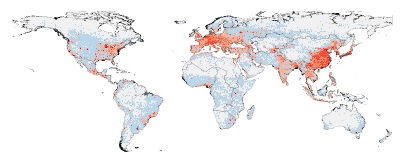

In [39]:
from matplotlib.collections import PatchCollection
import matplotlib as mpl
from collections import defaultdict
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import Polygon

m = Basemap(projection='cyl', llcrnrlon=-180,llcrnrlat=-64,urcrnrlon=180.,urcrnrlat=80)

#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='#ddaa66',lake_color='aqua')
#map.drawcoastlines()

fig_size = figsize(1, "golden")
f, ax = plt.subplots(1,1, figsize=fig_size)#, figsize=(15,10))

#m.readshapefile('../ema/data/shps_world/ne_10m_land', 'comarques')
background = np.hstack([np.array([241,241,241])/255., [1]])

m.readshapefile('../data/generated_files/borders_macro_simple', 'borders', color=(0,0,0,0.), linewidth=0.0, drawbounds=True)

patches = []
for shape in m.borders:
    #x, y = zip(*shape) 
    #ax.plot(x, y, marker=None, color=(0,0,0,0.4))
    patches.append(Polygon(shape))    #'#C3C3C3'

ax.add_collection(PatchCollection(patches, zorder=3, facecolor=(0,0,0,0), edgecolor=(0,0,0,0.9), linewidth=0.1))


m.readshapefile('../data/generated_files/simple', 'tiles', color=(0,0,0,0), linewidth=0.1)
#ax.set_title(title)

data = []
data_for_sorting = []
shapes = []
for info, shape in zip(m.tiles_info, m.tiles):
    #data.append(info['tile_km2'])
    data.append(info['perc_urban']*100)
    shapes.append(shape)
    
#sorted_indexes = np.argsort(data_for_sorting)

data = np.array(data)#[sorted_indexes]
shapes = np.array(shapes)#[sorted_indexes]
data[data < 0] = 0
data[data > 100] = 100
indexes = np.argwhere(data)[:, 0]
#data = data[indexes]
#shapes = shapes[indexes]
filtered_data = np.cumsum(data/data.sum())#[indexes]

num_colors = len(color_cmap)
#breaks = Jenks_Caspall(data, k=num_colors)
#breaks = Percentiles(data, pct=[80, 90, 95, 100])
#breaks = User_Defined(filtered_data, jenks(filtered_data, num_colors)[1:])
breaks = User_Defined(data, steps[1:])
discrete_data = np.zeros(data.shape, dtype=np.uint8)

discrete_data = np.array(breaks.yb, dtype=np.uint8)+1
new_color_cmap = np.vstack([background, color_cmap])


c = mpl.colors.ListedColormap(new_color_cmap)
#norm = plt.Normalize(vmin=np.min(data), vmax=np.max(data))
#color = lambda x: c(norm(x))

ccccs = []
patches = defaultdict(list)
for perc_urban, orig_data, shape in zip(discrete_data, data, shapes):
    patches[int(perc_urban)].append(Polygon(shape))    #'#C3C3C3'

for k, v in patches.items():
    color = c(k)
    ax.add_collection(PatchCollection(v, zorder=2, facecolor=color, edgecolor=color, linewidth=0.008))
 
#sns.despine(left=True, bottom=True, ax=ax)
ax.axis('off')
#plt.savefig('../figures/world-map.png', bbox_inches='tight', pad_inches=0.05, dpi=600)
#plt.savefig('../figures/world-map.pdf', bbox_inches='tight', pad_inches=0.05)

/home/denadai/.local/share/virtualenvs/ema-lfvilRpo/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/home/denadai/.local/share/virtualenvs/ema-lfvilRpo/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/home/denadai/.local/share/virtualenvs/ema-lfvilRpo/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


0.0 9.394476654540665e-15
0.009995137590084868 0.48112704249172644
1.4299270454491175 0.8612891089885891
3.9997852903046014 0.933903634799437
9.99545675674227 0.9750001549137479
29.951914577328015 0.9967290458728277
59.937981547249706 0.9996207440215336


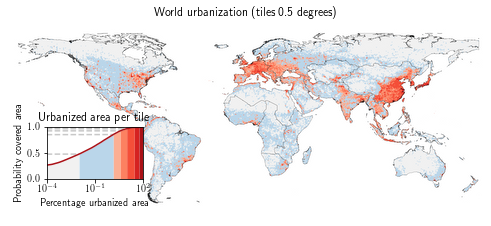

In [45]:
import matplotlib.image as mpimg

f, ax = plt.subplots(1,1, figsize=fig_size)

img=mpimg.imread('../figures/world-map.png')
imgplot = plt.imshow(img, aspect='equal', interpolation='lanczos')
ax.axis('off')

X = df_summary['percent_urban'].values
Y = np.cumsum(df_summary['tile_km2_norm'].values)
#Y = Y/Y[-1]

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
inset_ax = inset_axes(ax,
                    width="20%", # width = 30% of parent_bbox
                    height=fig_size[1]/6, # height : 1 inch
                    loc=3, borderpad=4)

inset_ax.plot(X, Y, color=new_color_cmap[-1])
inset_ax, global_coordinates = fill_intervals(inset_ax, steps, X, Y)

inset_ax.set_xscale('log')
inset_ax.set_xlim(10**-4, 100.0)
inset_ax.set_ylim(0, 1.00)

inset_ax.set_title("Urbanized area per tile")
inset_ax.set_xlabel("Percentage urbanized area")
inset_ax.set_ylabel("Probability covered area")

ax.set_title("World urbanization (tiles 0.5 degrees)")

plt.tight_layout()
#plt.savefig('figures/world_map.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)

# Macro plots

16 macroareas
Australia N. Zealand
0.0 6.18959479525531e-11
0.009971957048292356 0.7539143116123601
1.4110930965169282 0.9802475233695869
3.9733751424997097 0.9926580576996962
9.881155185590163 0.9955043645281155
26.2862375837758 0.9988597197415603
41.09575505371024 0.999891540898841
 
Central America
0.0 6.6218431500938545e-09
0.009750932699701455 0.1478495601086152
1.4282211526348485 0.7655467801132825
3.9917074506059325 0.91936441572266
9.948545518237282 0.9773713224447282
28.007616115390928 0.9983542673563433
49.059872351547895 0.999971219774338
 
Central Asia
0.0 5.139825275312513e-08
0.009975937072854008 0.5213265505959751
1.4261839411374873 0.9341361224677204
3.965418831578623 0.9676997863361818
9.605770808889035 0.9894013714305393
29.855496230835577 0.999854529078617
36.4875715021449 0.9999999999999998
 
Eastern Africa
0.0 1.9463149760494085e-13
0.009882570112008106 0.4013561632341118
1.4151591414388995 0.965991493351558
3.9275776202158443 0.9914066524918058
9.527896648555027 0

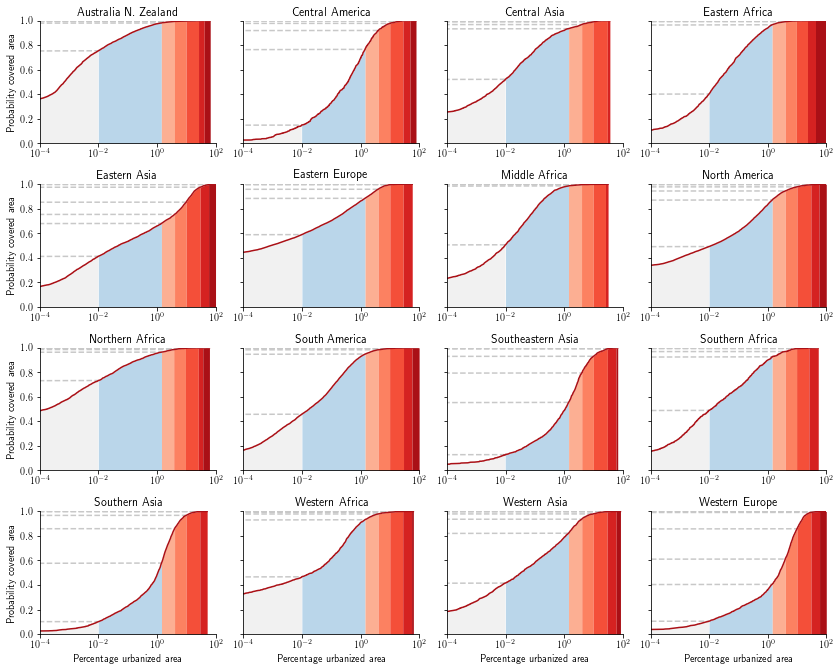

In [46]:
macros = df['macro'].drop_duplicates().values
n_macros = len(set(macros))

print(n_macros, "macroareas")

fig_size = figsize(1.7, 0.8)
f, axs = plt.subplots(4,4, figsize=fig_size, sharey=True)

i = 0
macro_coordinates = {}
for irow, row in enumerate(axs):
    for icol, ax in enumerate(row):
        macro = macros[i]
        print(macro)
        i += 1
        
        df_macro = df[df['macro'] == macro]
        X = df_macro['percent_urban'].values
        Y = np.cumsum((df_macro['tile_km2']/df_macro['tile_km2'].sum()).values)
        #Y = Y/Y[-1]

        ax.plot(X,Y, color=color_cmap[-1])
        ax.set_xscale('log')
        ax.set_xlim(10**-4, 100)
        ax.set_ylim(0,1)
        
        ax, macro_coordinates[macro] = fill_intervals(ax, steps, X, Y)
        
        #ax.set_title("Urbanized area per tile (0.5 degrees)")
        ax.set_title(macro)
        
        if icol == 0:
            ax.set_ylabel("Probability covered area")
        if irow == 3:
            ax.set_xlabel("Percentage urbanized area")
        print(" ")
sns.despine()

plt.tight_layout()
#plt.savefig('figures/macro_cumulative.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)

In [187]:
coordinates_list = []
for k,v in macro_coordinates.items():
    for e in v:
        coordinates_list.append([k] + e)
coordinates_df = pd.DataFrame().from_records(coordinates_list, columns=['macro', 'lower_X', 'upper_X', 'lower_Y', 'upper_Y'])
coordinates_df.head()

,macro,lower_X,upper_X,lower_Y,upper_Y
0,Australia N. Zealand,0.00,0.01,6.189595e-11,0.753914
1,Australia N. Zealand,0.01,1.43,7.539143e-01,0.980248
2,Australia N. Zealand,1.43,4.00,9.802475e-01,0.992658
3,Australia N. Zealand,4.00,10.00,9.926581e-01,0.995504
4,Australia N. Zealand,10.00,30.00,9.955044e-01,0.998860


In [188]:
coordinates_df.to_csv('data/generated_files/macro_plot_coordinates.csv', index=False)

In [189]:
'''aa = df[df['macro'] == 'North America']['tile_km2'].values

X = df[df['macro'] == 'North America']['percent_urban'].values
Y = np.cumsum(aa)
Y = Y/Y[-1]

f, ax = plt.subplots(1,1)

ax.plot(X,Y, color=color_cmap[-1])
ax.set_xscale('log')
ax.set_xlim(10**-4, 100)
ax.set_ylim(0,1)
        
ax = fill_intervals(ax, steps, X, Y)
'''

"aa = df[df['macro'] == 'North America']['tile_km2'].values\n\nX = df[df['macro'] == 'North America']['percent_urban'].values\nY = np.cumsum(aa)\nY = Y/Y[-1]\n\nf, ax = plt.subplots(1,1)\n\nax.plot(X,Y, color=color_cmap[-1])\nax.set_xscale('log')\nax.set_xlim(10**-4, 100)\nax.set_ylim(0,1)\n        \nax = fill_intervals(ax, steps, X, Y)\n"

## Quantiles real

In [38]:
df_quantiles = pd.read_csv('../data/generated_files/quantiles_classes.csv', dtype={'tileid': str})
df_quantiles = df_quantiles.set_index('tileid')
df_quantiles['class'] = df_quantiles['class'].astype('int')
print(len(df_quantiles))
df_quantiles.head()

44240


,class,quantile
tileid,,
46588,2,0.307
47297,3,0.544
48000,2,0.428
48003,3,0.811
48004,2,0.353


In [39]:
urb_classes_colors = np.array([
    [237, 129, 69],
    [249, 227, 147],
    [226, 241, 199],
    [140, 169, 181],
])
urb_classes_colors  = urb_classes_colors/255.

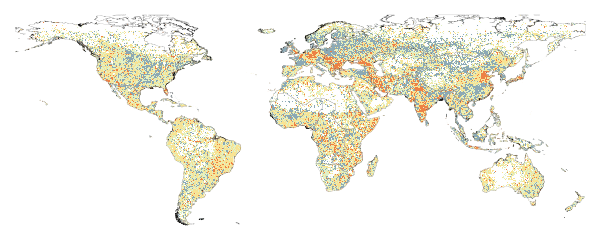

In [40]:
def create_tile_map(classname, ax):
    m = Basemap(projection='cyl', llcrnrlon=-180,llcrnrlat=-64,urcrnrlon=180.,urcrnrlat=80, ax=ax)
    m.readshapefile('../data/generated_files/borders_macro_simple', 'borders', color=(0,0,0,0.), linewidth=0.0, drawbounds=True)

    patches = []
    for shape in m.borders:
        patches.append(Polygon(shape))
    ax.add_collection(PatchCollection(patches, zorder=3, facecolor=(0,0,0,0), edgecolor=(0,0,0,0.9), linewidth=0.1))

    m.readshapefile('../data/generated_files/simple', 'tiles', color=(0,0,0,0), linewidth=0.1)
    shapes = defaultdict(list)
    for info, shape in zip(m.tiles_info, m.tiles):
        tile_id = str(info['tileid'])
        if tile_id in df_quantiles.index:
            urb_class = df_quantiles.loc[tile_id, classname]
            shapes[urb_class].append(Polygon(shape))

    for k, v in shapes.items():
        c = urb_classes_colors[k-1]
        ax.add_collection(PatchCollection(v, zorder=2, facecolor=c, edgecolor=c, linewidth=0.008))

fig_size = figsize(1.5, "golden")
f, ax = plt.subplots(1, 1, figsize=fig_size)#, figsize=(15,10))
background = np.hstack([np.array([241,241,241])/255., [1]])

## REAL WORLD
create_tile_map('class', ax)

ax.axis('off')

#f.savefig('../figures/manuscript/delete.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)
f.savefig('../figures/manuscript/figure3_map_raster.png', bbox_inches='tight', pad_inches=0.05, dpi=300)

## Quantiles world

In [34]:
df_quantiles = pd.read_csv('../data/generated_files/quantiles_classes_merged_all.csv', dtype={'tileid': str})
df_quantiles = df_quantiles.set_index('tileid')
df_quantiles['class_truth'] = df_quantiles['class_truth'].astype('int')
print(len(df_quantiles))
df_quantiles.head()

8938


,class_1000,quantile_1000,class_rybski,quantile_rybski,class_marco,quantile_marco,class_truth,quantile_truth
tileid,,,,,,,,
50123,2,0.180,2,0.173,2,0.209,2,0.126
52250,2,0.153,2,0.199,2,0.196,2,0.166
60513,2,0.219,2,0.343,2,0.303,2,0.247
60749,2,0.285,2,0.143,2,0.189,2,0.166
61225,2,0.104,1,0.087,2,0.109,1,0.079


In [35]:
urb_classes_colors = np.array([
    [237, 129, 69],
    [249, 227, 147],
    [226, 241, 199],
    [140, 169, 181],
])
urb_classes_colors  = urb_classes_colors/255.

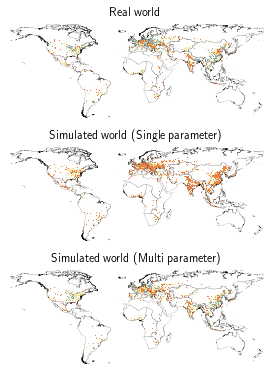

In [36]:
def create_tile_map(classname, ax):
    m = Basemap(projection='cyl', llcrnrlon=-180,llcrnrlat=-64,urcrnrlon=180.,urcrnrlat=80, ax=ax)
    m.readshapefile('../data/generated_files/borders_macro_simple', 'borders', color=(0,0,0,0.), linewidth=0.0, drawbounds=True)

    patches = []
    for shape in m.borders:
        patches.append(Polygon(shape))
    ax.add_collection(PatchCollection(patches, zorder=3, facecolor=(0,0,0,0), edgecolor=(0,0,0,0.9), linewidth=0.1))

    m.readshapefile('../data/generated_files/simple', 'tiles', color=(0,0,0,0), linewidth=0.1)
    shapes = defaultdict(list)
    for info, shape in zip(m.tiles_info, m.tiles):
        tile_id = str(info['tileid'])
        if tile_id in df_quantiles.index:
            urb_class = df_quantiles.loc[tile_id, classname]
            shapes[urb_class].append(Polygon(shape))

    for k, v in shapes.items():
        c = urb_classes_colors[k-1]
        ax.add_collection(PatchCollection(v, zorder=2, facecolor=c, edgecolor=c, linewidth=0.008))

fig_size = figsize(1.5, "golden")
f, axs = plt.subplots(3, 1, figsize=fig_size)#, figsize=(15,10))
background = np.hstack([np.array([241,241,241])/255., [1]])

## REAL WORLD
create_tile_map('class_truth', axs[0])

## SIMULATED WORLD RYBSKI
create_tile_map('class_rybski', axs[1])

## SIMULATED WORLD
create_tile_map('class_1000', axs[2])
    
axs[0].set_title("Real world")
axs[1].set_title("Simulated world (Single parameter)")
axs[2].set_title("Simulated world (Multi parameter)")
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

f.savefig('../figures/manuscript/simulated-world-map.png', bbox_inches='tight', pad_inches=0.05, dpi=300)